In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
import matplotlib.colors as cm
import utils_PLS as upls

volumes = ace.clean_volumes_database()

root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'Black_wf_WholeBrain'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]

def load_subject(subject, data_directory, threshold):
    file_suffix = 'cells_' + str(threshold)
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

thresholds = [500, 1500, 2500, 3500, 4500]

In [2]:
subjects = ['BL45Control', 'BL51Control', 'BL53Control',
           'BL47Fam', 'BL49Fam', 'BL50Fam',
           'BL46Unfam', 'BL48Unfam', 'BL52Unfam', 'BL54Unfam']
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['BL45Control', 'BL51Control', 'BL53Control'],
 'Fam': ['BL47Fam', 'BL49Fam', 'BL50Fam'],
 'Unfam': ['BL46Unfam', 'BL48Unfam', 'BL52Unfam', 'BL54Unfam']}

In [3]:
def sum_values(subjects, thresholds):
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells', 'energy', 'density', 'relative_density'])
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        data[metric] = [pd.read_csv(
            data_directory+subject+'/'+subject+str(threshold)+'.csv')[metric].sum() \
                        for subject in subjects for threshold in thresholds]
    return data


In [4]:
def plot_values(data):
    fig, axes = plt.subplots(2,2, figsize=(10,10))
    plt.subplots_adjust(hspace=0.06)
    palette='Set2'
    sns.lineplot(data=data, x='subject', y='n_cells', hue='threshold', ax=axes[0][0], legend=False, 
                 palette=palette)
    axes[0][0].tick_params(labelbottom=False) 
    axes[0][0].set_xlabel('')

    sns.lineplot(data=data, x='subject', y='energy', hue='threshold', ax=axes[0][1], 
                 palette=palette)
    axes[0][1].legend().set_title('')
    axes[0][1].tick_params(labelbottom=False)
    axes[0][1].set_xlabel('')

    sns.lineplot(data=data, x='subject', y='density', hue='threshold', ax=axes[1][0], legend=False, 
                 palette=palette)
    axes[1][0].tick_params(axis='x', rotation=90)
    axes[1][0].set_xlabel('')

    sns.lineplot(data=data, x='subject', y='relative_density', hue='threshold', ax=axes[1][1], legend=False, 
                 palette=palette)
    axes[1][1].tick_params(axis='x', rotation=90)
    axes[1][1].set_xlabel('')

In [5]:
def find_significant_areas(dictionary, experimental_groups):
    df_control, df_fam, df_unfam = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value='n_cells')
    df_ttest = ace.test_across_groups([df_control,
                                       df_fam,
                                       df_unfam])
    # remove rows corresponding to area that have zero cell count across all experimental groups
    df_ttest = df_ttest.dropna(axis=0,
                               how='all',
                               subset=['pval_Control_vs_Fam',
                                       'pval_Control_vs_Unfam',
                                       'pval_Fam_vs_Unfam'])
    # sort dataframe pvalues of control vs fam and pick the first 20
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<0.05]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

In [6]:
def calculate_ratio_detected_cells(subjects, thresholds):
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells_analysis', 'n_detected_cells', 'ratio'])
    data_sum = sum_values(subjects=subjects, thresholds=thresholds)
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]

    n_cells = []
    n_detected_cells = []
    ratio = []
    for subject in subjects:
        for threshold in thresholds:
            sum_n = data_sum[(data_sum['subject']==subject) & 
                                    (data_sum['threshold']==threshold)]['n_cells'].item()
            n_cells.append(sum_n)
            det_n = len(pd.read_csv(data_directory+subject+'/cells_'+str(threshold)+'.csv',
                                                   low_memory=False))
            n_detected_cells.append(det_n)
            ratio.append(sum_n/det_n)


    data['n_cells_analysis'] = n_cells
    data['n_detected_cells'] = n_detected_cells
    data['ratio'] = ratio
    return data

# Plot ratio of detected cells over cells used for analysis

In [7]:
ratio = calculate_ratio_detected_cells(subjects=subjects, 
                                       thresholds=thresholds)

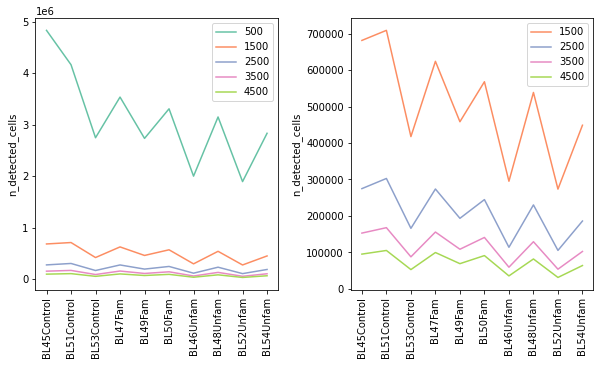

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.lineplot(data=ratio, x='subject', y='n_detected_cells', hue='threshold', ax=axes[0], 
             legend=True, palette='Set2')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
axes[0].legend().set_title('')

cmap = [plt.cm.Set2(i) for i in range(1, 5)]
sns.lineplot(data=ratio[ratio['threshold']!=500], 
             x='subject', y='n_detected_cells', hue='threshold', ax=axes[1], legend=True
            , palette=cmap)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')
axes[1].legend().set_title('')

Text(0.5, 1.0, 'Excluding threshold 500')

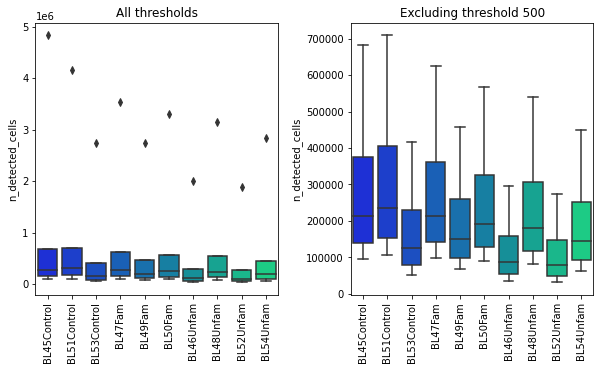

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.boxplot(data=ratio, x='subject', y='n_detected_cells', ax=axes[0], 
             palette='winter')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
axes[0].set_title('All thresholds')

sns.boxplot(data=ratio[ratio['threshold']!=500], 
             x='subject', y='n_detected_cells', ax=axes[1], 
            palette='winter')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')
axes[1].set_title('Excluding threshold 500')

Text(0.5, 0, '')

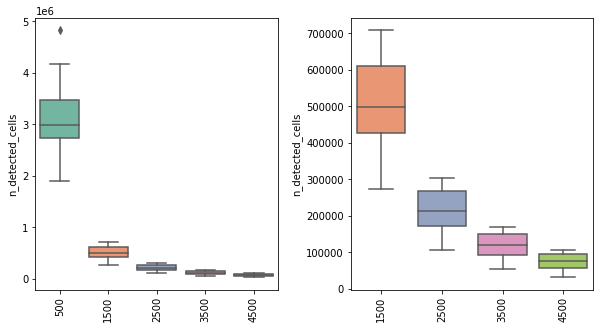

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.boxplot(data=ratio, x='threshold', y='n_detected_cells', ax=axes[0], 
             palette='Set2')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
cmap = [plt.cm.Set2(i) for i in range(1, 5)]
sns.boxplot(data=ratio[ratio['threshold']!=500], 
             x='threshold', y='n_detected_cells', ax=axes[1], 
            palette=cmap)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')

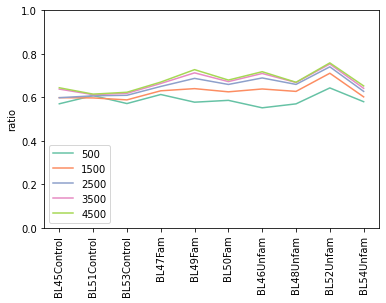

In [11]:
fig, axes = plt.subplots(1,1)
plt.subplots_adjust(hspace=0.06)
sns.lineplot(data=ratio, x='subject', y='ratio', hue='threshold', ax=axes, legend=True, palette='Set2')
axes.tick_params(axis='x', rotation=90)
axes.set_xlabel('')
axes.set_ylim([0,1])
plt.gca().legend().set_title('')

(0.0, 1.0)

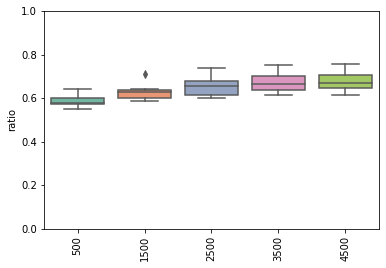

In [12]:
fig, axes = plt.subplots(1,1)
plt.subplots_adjust(hspace=0.06)
sns.boxplot(data=ratio, x='threshold', y='ratio', ax=axes, palette='Set2')
axes.tick_params(axis='x', rotation=90)
axes.set_xlabel('')
axes.set_ylim([0,1])

# Plot total number of cells

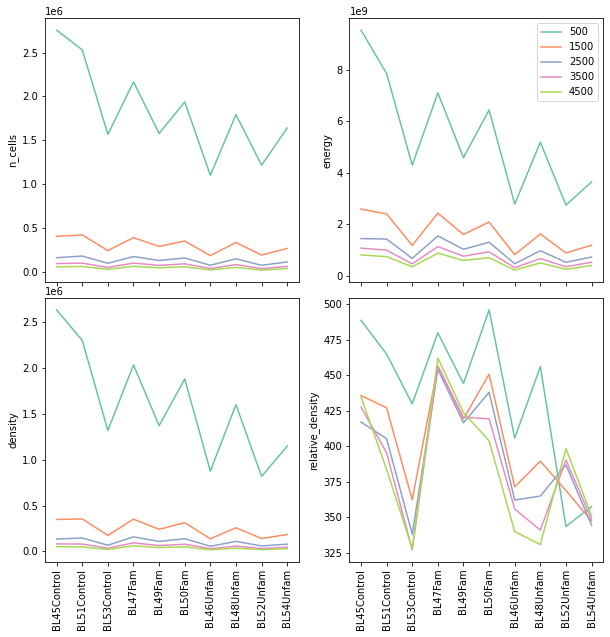

In [13]:
data = sum_values(subjects=subjects, thresholds=thresholds)

plot_values(data)

# Plot single areas

In [14]:
def dataframe_areas(area, subjects, thresholds):
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells', 'energy', 'density', 'relative_density'])
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        values = []
        for subject in subjects:
            for threshold in thresholds:
                v = pd.read_csv(data_directory+subject+'/'+subject+str(threshold)+'.csv')
                values.append(v[v['area']==area][metric].values[0])
        data[metric] = [v for v in values]
    return data


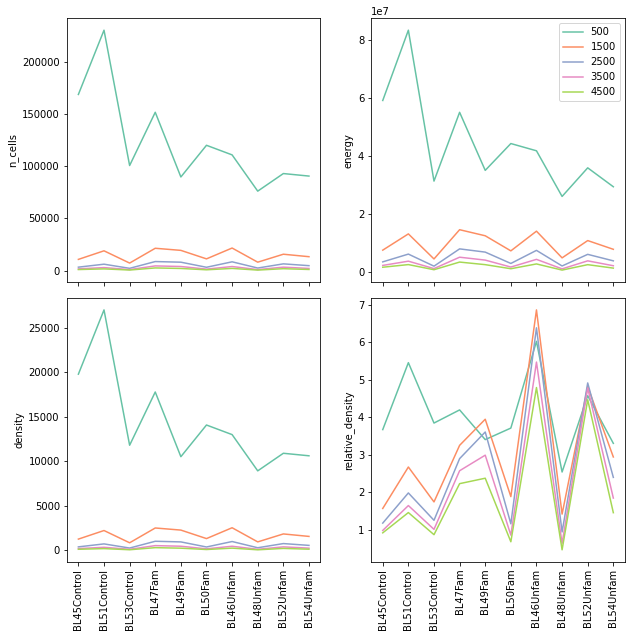

In [15]:
data = dataframe_areas(area="Main olfactory bulb",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)

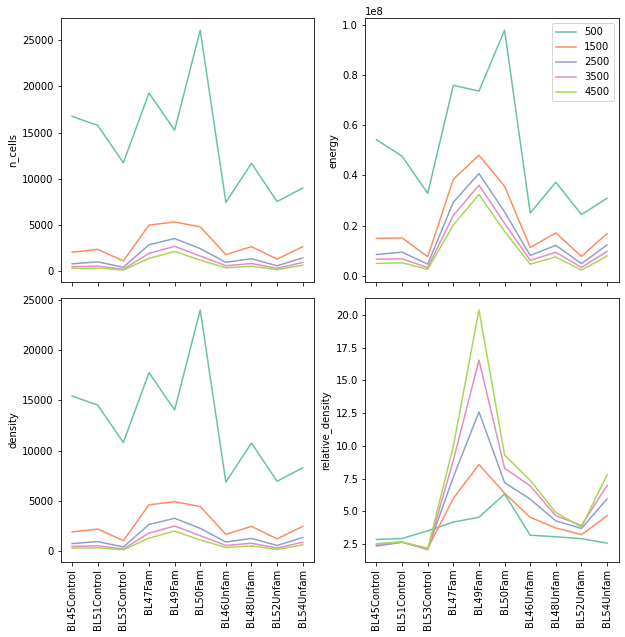

In [16]:
data = dataframe_areas(area="Medial amygdalar nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)

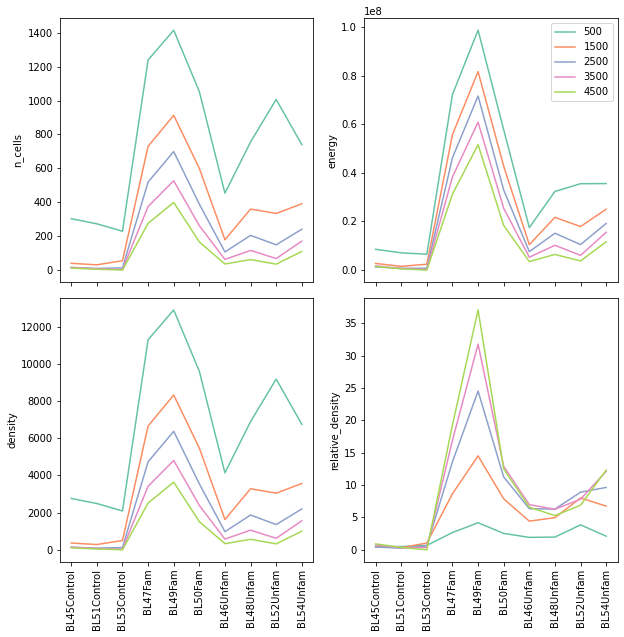

In [17]:
data = dataframe_areas(area="Ventral premammillary nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)

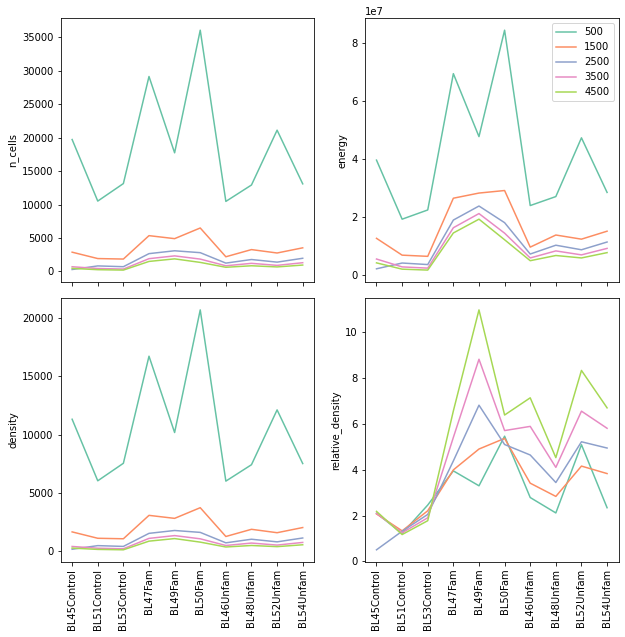

In [18]:
data = dataframe_areas(area="Cortical amygdalar area",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)

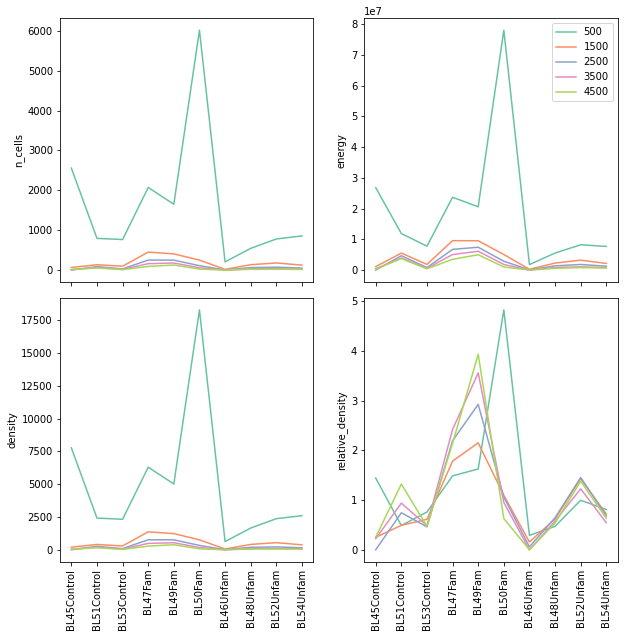

In [19]:
data = dataframe_areas(area="Arcuate hypothalamic nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)

# Analysis 500

In [20]:
dict500 = np.load('dict_results/dict_results_across_mice_Black_wf_WholeBrain500.npy', 
                                   allow_pickle=True).item()
df_sigareas500 = find_significant_areas(dictionary=dict500,
                                    experimental_groups=experimental_groups)
df_sigareas500

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Ventral premammillary nucleus,Anterior olfactory nucleus,Paraventricular nucleus of the thalamus
1,Posterior amygdalar nucleus,Anteroventral preoptic nucleus,Tuberomammillary nucleus
2,Periventricular hypothalamic nucleus posterior...,Lateral habenula,Ventrolateral preoptic nucleus
3,Ventrolateral preoptic nucleus,Anterodorsal preoptic nucleus,Periventricular hypothalamic nucleus posterior...
4,Rhomboid nucleus,Ventral premammillary nucleus,Posterior amygdalar nucleus
5,NaN,Lateral posterior nucleus of the thalamus,Medial amygdalar nucleus
6,NaN,Medial amygdalar nucleus,Tuberal nucleus
7,NaN,Nucleus accumbens,Retrosplenial area
8,NaN,Parafascicular nucleus,Midbrain reticular nucleus
9,NaN,Medial septal complex,Anteroventral preoptic nucleus


In [21]:
dict1500 = np.load('dict_results/dict_results_across_mice_Black_wf_WholeBrain1500.npy', 
                                   allow_pickle=True).item()
df_sigareas1500 = find_significant_areas(dictionary=dict1500,
                                    experimental_groups=experimental_groups)
df_sigareas1500

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Medial amygdalar nucleus,Ventral premammillary nucleus,Medial amygdalar nucleus
1,Ventral premammillary nucleus,Lateral habenula,Cortical amygdalar area
2,Posterior amygdalar nucleus,Central lateral nucleus of the thalamus,Intercalated amygdalar nucleus
3,Cortical amygdalar area,Taenia tecta,Paraventricular nucleus of the thalamus
4,Piriform-amygdalar area,Parafascicular nucleus,Ventrolateral preoptic nucleus
5,Tuberomammillary nucleus,Rostral linear nucleus raphe,Ventral premammillary nucleus
6,Arcuate hypothalamic nucleus,Ventral tegmental area,Midbrain reticular nucleus
7,Posterodorsal preoptic nucleus,Anterior olfactory nucleus,Posterior amygdalar nucleus
8,Periventricular hypothalamic nucleus posterior...,Nucleus accumbens,Posterolateral visual area
9,Intercalated amygdalar nucleus,Lateral posterior nucleus of the thalamus,Basomedial amygdalar nucleus


In [22]:
dict2500 = np.load('dict_results/dict_results_across_mice_Black_wf_WholeBrain2500.npy', 
                                   allow_pickle=True).item()
df_sigareas2500 = find_significant_areas(dictionary=dict2500,
                                    experimental_groups=experimental_groups)
df_sigareas2500

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Cortical amygdalar area,Subthalamic nucleus,Cortical amygdalar area
1,Posterior amygdalar nucleus,Ventral premammillary nucleus,Intercalated amygdalar nucleus
2,Piriform-amygdalar area,Cortical amygdalar area,Medial amygdalar nucleus
3,Medial amygdalar nucleus,Piriform-amygdalar area,Superior colliculus motor related
4,Ventral premammillary nucleus,Lateral posterior nucleus of the thalamus,Posterior amygdalar nucleus
5,Basomedial amygdalar nucleus,Anterior hypothalamic nucleus,Ventral premammillary nucleus
6,Intercalated amygdalar nucleus,Parafascicular nucleus,Posterolateral visual area
7,Piriform area,Pretectal region,Basomedial amygdalar nucleus
8,Nucleus of the lateral olfactory tract,Vascular organ of the lamina terminalis,Anterodorsal nucleus
9,Periventricular hypothalamic nucleus posterior...,Ventral tegmental area,Midbrain reticular nucleus


In [23]:
dict3500 = np.load('dict_results/dict_results_across_mice_Black_wf_WholeBrain3500.npy', 
                                   allow_pickle=True).item()
df_sigareas3500 = find_significant_areas(dictionary=dict3500,
                                    experimental_groups=experimental_groups)
df_sigareas3500

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Cortical amygdalar area,Lateral posterior nucleus of the thalamus,Intercalated amygdalar nucleus
1,Posterior amygdalar nucleus,Cortical amygdalar area,Superior colliculus motor related
2,Medial amygdalar nucleus,Pretectal region,Cortical amygdalar area
3,Ventral premammillary nucleus,Ventral premammillary nucleus,Posterior amygdalar nucleus
4,Piriform-amygdalar area,Posterior amygdalar nucleus,Trochlear nucleus
5,Intercalated amygdalar nucleus,Subthalamic nucleus,Medial amygdalar nucleus
6,Tuberomammillary nucleus,Orbital area,Posterior hypothalamic nucleus
7,Posterodorsal preoptic nucleus,Superior colliculus motor related,Basomedial amygdalar nucleus
8,Periventricular hypothalamic nucleus posterior...,NaN,Ventral premammillary nucleus
9,Medial preoptic area,NaN,Anterodorsal nucleus


In [24]:
dict4500 = np.load('dict_results/dict_results_across_mice_Black_wf_WholeBrain4500.npy', 
                                   allow_pickle=True).item()
df_sigareas4500 = find_significant_areas(dictionary=dict4500,
                                    experimental_groups=experimental_groups)
df_sigareas4500

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Cortical amygdalar area,Cortical amygdalar area,Lateral terminal nucleus of the accessory opti...
1,Posterior amygdalar nucleus,Lateral posterior nucleus of the thalamus,Intercalated amygdalar nucleus
2,Subgeniculate nucleus,Posterior amygdalar nucleus,Superior colliculus motor related
3,Intercalated amygdalar nucleus,Pretectal region,Posterior hypothalamic nucleus
4,Medial amygdalar nucleus,Paraventricular hypothalamic nucleus descendin...,Zona incerta
5,Piriform-amygdalar area,Superior colliculus motor related,Posterior amygdalar nucleus
6,Ventral premammillary nucleus,Orbital area,Cortical amygdalar area
7,Periventricular hypothalamic nucleus posterior...,Anterior olfactory nucleus,Basomedial amygdalar nucleus
8,NaN,Ventral premammillary nucleus,Medial amygdalar nucleus
9,NaN,Piriform-amygdalar area,Ventral premammillary nucleus


## Find common areas across all thresholds

In [25]:
# common areas in Control_vs_Fam
common_areas = {tag: 
list(set(df_sigareas500[tag].dropna()).intersection(
df_sigareas1500[tag].dropna()).intersection(
df_sigareas2500[tag].dropna()).intersection(
df_sigareas3500[tag].dropna()).intersection(
df_sigareas4500[tag].dropna()))
                for tag in df_sigareas500.columns}
common_areas

{'Control_vs_Fam': ['Posterior amygdalar nucleus',
  'Periventricular hypothalamic nucleus posterior part',
  'Ventral premammillary nucleus'],
 'Control_vs_Unfam': ['Lateral posterior nucleus of the thalamus',
  'Ventral premammillary nucleus',
  'Orbital area'],
 'Fam_vs_Unfam': ['Posterolateral visual area',
  'Posterior amygdalar nucleus',
  'Periventricular hypothalamic nucleus posterior part',
  'Subparaventricular zone',
  'Paraventricular nucleus of the thalamus',
  'Ventral auditory area',
  'Midbrain reticular nucleus',
  'Medial amygdalar nucleus',
  'Dorsomedial nucleus of the hypothalamus',
  'Intercalated amygdalar nucleus',
  'Ventral premammillary nucleus']}

## Number of significant areas

In [26]:
number_sig_area = pd.DataFrame(columns=['threshold']+ [col for col in df_sigareas500.columns])
for df, t in zip([df_sigareas500,
                df_sigareas1500,
                df_sigareas2500,
                df_sigareas3500,
                df_sigareas4500],
                thresholds):
    number_sig_area.loc[len(number_sig_area.index)] = [t, 
                                                       len(df['Control_vs_Fam'].dropna()),
                                                       len(df['Control_vs_Unfam'].dropna()),
                                                       len(df['Fam_vs_Unfam'].dropna())]

Text(0.5, 0, '')

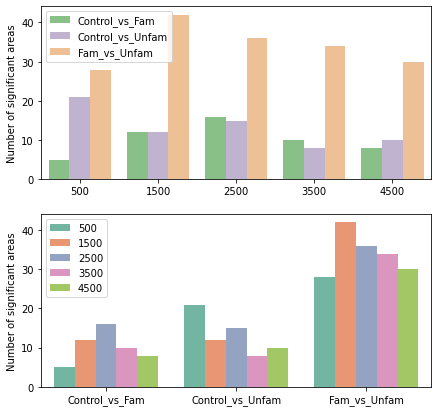

In [27]:
plot_number_sig_area = number_sig_area.set_index('threshold').stack()\
    .reset_index(name='Number of significant areas').rename(columns={'level_1':'group'})

fig, axes = plt.subplots(2,1, figsize=(7,7))
sns.barplot(data=plot_number_sig_area, x='threshold',
            y='Number of significant areas', hue='group', ax=axes[0], palette='Accent')
axes[0].legend().set_title('')
axes[0].set_xlabel('')
sns.barplot(data=plot_number_sig_area, x='group',
            y='Number of significant areas', hue='threshold', ax=axes[1], palette='Set2')
axes[1].legend().set_title('')
axes[1].set_xlabel('')


## Show correlation matrices

In [28]:
def corr_matrix(experimental_groups,
               dict_results_across_mice,
               value='n_cells'):
    n_groups = len(experimental_groups.keys())
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dict_results_across_mice, 
                                  value=value)
    # rename areas with acronyms
    for df in dfs:
        for i in df.index:
            df.at[i, 'area'] = volumes[volumes['safe_name'] == \
                                       df.at[i, 'area']]['acronym'].values[0]
    # remove null values
    for df in dfs:
        df = df.set_index('area').loc[
                ~(df.set_index('area')==0).all(axis=1)].dropna(axis=0)
    
    df1, df2, df3 = dfs
    indexes_intersect = df1.index.intersection(df2.index).intersection(df3.index)
    print(indexes_intersect)
    corr_matrices = []
    for df in dfs:
        df = df.loc[indexes_intersect]
        # check here why it is empty
        corr_matrices.append(df.set_index('area').T.corr(method='pearson'))
    return corr_matrices

In [29]:
corr_matrices = [corr_matrix(experimental_groups=experimental_groups,
                           dict_results_across_mice=dictionary) for dictionary in [dict500, 
                                                                                   dict1500,
                                                                                   dict2500,
                                                                                   dict3500,
                                                                                   dict4500]] 

RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)


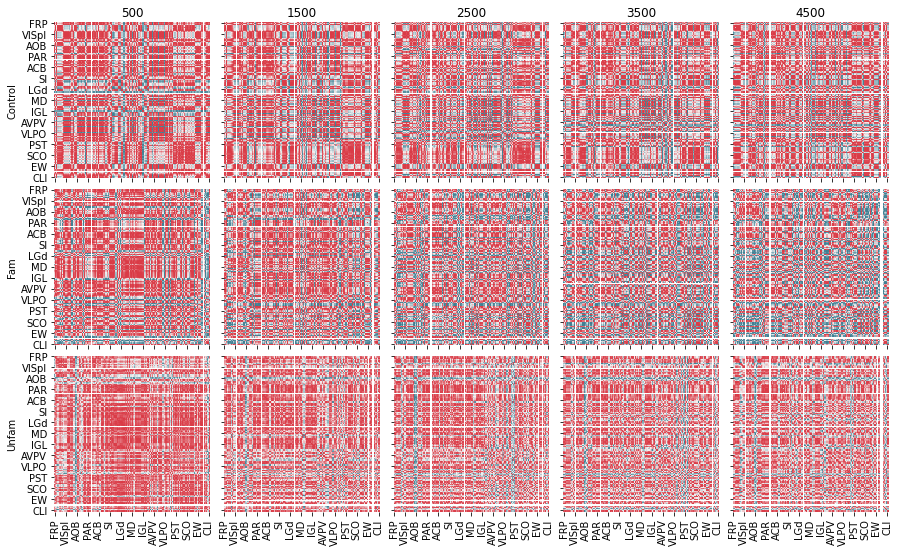

In [30]:
f, ax = plt.subplots(3,5, figsize=(15, 9), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.07, wspace=0.07)
group_labels = ['Control', 'Fam', 'Unfam']
for i, threshold in enumerate(corr_matrices):
    for j, matrix in enumerate(threshold):
        sns.heatmap(matrix,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0,
        square=True, cbar=False, ax=ax[j][i])
        ax[j][i].set_xlabel('')
        ax[j][i].set_ylabel('') if i!=0 else ax[j][i].set_ylabel(group_labels[j])
        if j==0:
            ax[j][i].set_title(str(thresholds[i]))

# Analysis Task PLS

In [31]:
df_levels = upls.create_df_levels(volumes)
for i, dictionary in enumerate([dict500,dict1500,dict2500,dict3500,dict4500]):
    dictionary = upls.reformat_dict_acronym(dict_results=dictionary,
                                            volumes=volumes)
    data_relative_density = upls.format_data_pls(dict_results=dictionary, 
                                                 batch='BL_wf_WholeBrain'+str(thresholds[i]), 
                                                 table='relative_density')
    data_relative_density.dropna(inplace=True, axis=1)
    data_relative_density.to_csv('./results_pls/BL_wf_WholeBrain'+str(thresholds[i])\
                                 +'_relative_density.csv')

In [32]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain500_relative_density.csv -o './results_pls/BL_wf_WholeBrain500_relative_density'

In [33]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain1500_relative_density.csv -o './results_pls/BL_wf_WholeBrain1500_relative_density'

In [34]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain2500_relative_density.csv -o './results_pls/BL_wf_WholeBrain2500_relative_density'

In [35]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain3500_relative_density.csv -o './results_pls/BL_wf_WholeBrain3500_relative_density'

In [36]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain4500_relative_density.csv -o './results_pls/BL_wf_WholeBrain4500_relative_density'

In [37]:
# for t in thresholds:
#     upls.plot_panel_contrasts(batch='BL_wf_WholeBrain'+str(t), 
#                               variable='relative_density')
#     upls.plot_panel_saliences(batch='BL_wf_WholeBrain'+str(t), 
#                               variable='relative_density', 
#                               df_levels=df_levels)

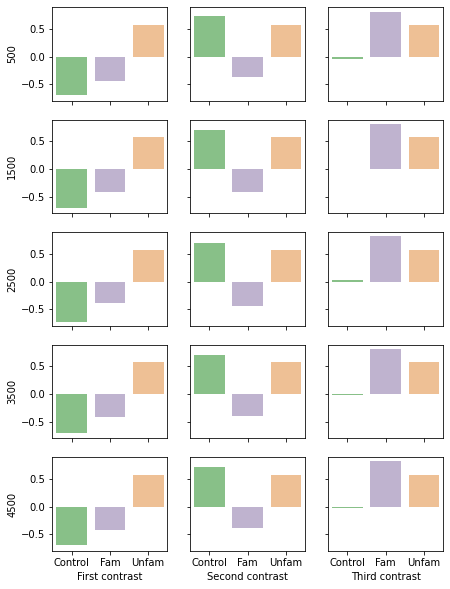

In [89]:
fig, axes = plt.subplots(5,3, figsize=(7,10), sharey=True, sharex=True)
for i in range(len(thresholds)):
    contrasts = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_contrasts.csv')
    contrasts = contrasts.rename(columns={"group_Control": "Control",
                                          "group_Fam": "Fam",
                                          "group_Unfam":"Unfam"})
    for j in range(3):
        upls.plot_contrasts(df_data=contrasts, index=j, ax=axes[i][j], palette='Accent')
        axes[i][j].set_xlabel(['First contrast',
                                  'Second contrast',
                                  'Third contrast'][j]) if i == 4 else axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel(thresholds[i]) if j == 0 else axes[i][j].set_ylabel('')


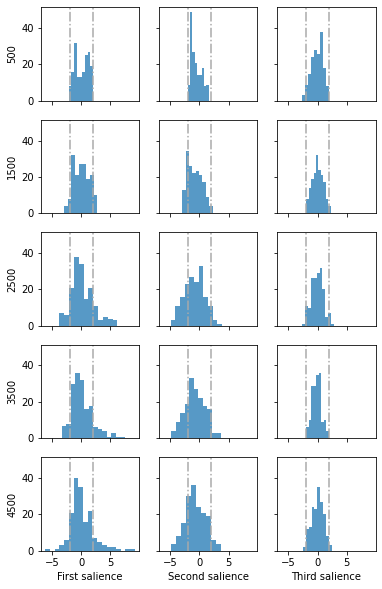

In [86]:
fig, axes = plt.subplots(5,3, figsize=(6,10), sharex=True, sharey=True)
plt.rcParams['patch.edgecolor'] = 'none'
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    for j in range(3):
        sns.histplot(saliences.T[j], ax=axes[i][j])
        axes[i][j].axvline(x=1.96, linestyle='-.', color='darkgrey')
        axes[i][j].axvline(x=-1.96, linestyle='-.', color='darkgrey')
        axes[i][j].set_xlabel(['First salience',
                                  'Second salience',
                                  'Third salience'][j])    
        if j==0:
            axes[i][j].set_ylabel(thresholds[i])

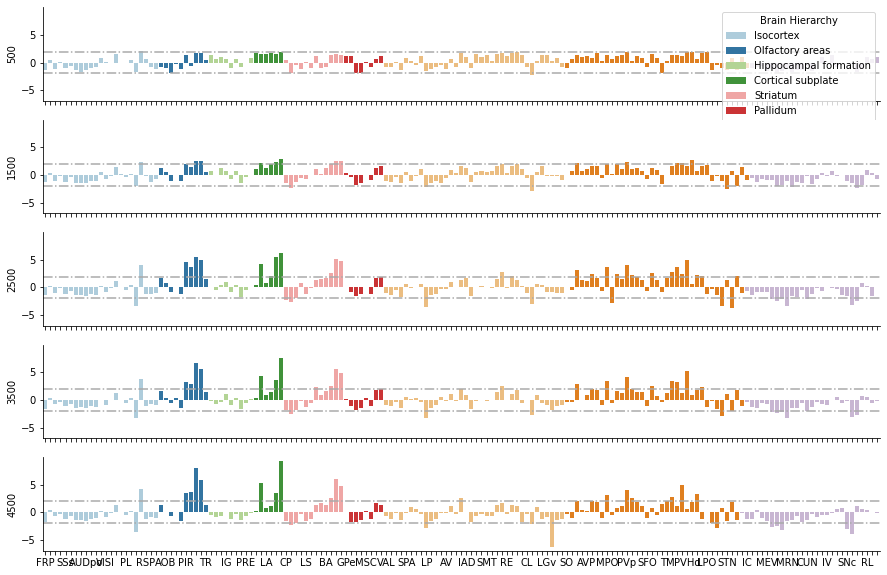

In [70]:
df_levels = upls.create_df_levels(volumes)
fig, axes = plt.subplots(5,1, figsize=(15,10), sharey=True, sharex=True)
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    upls.plot_saliences(df_data=saliences, df_levels=df_levels, 
                        index=0, ax=axes[i], palette='Paired')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(thresholds[i])
    if i!=0:
        axes[i].get_legend().remove()
    sns.despine(left=False, bottom=False)
    n = 4  # Keeps every 7th label
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]

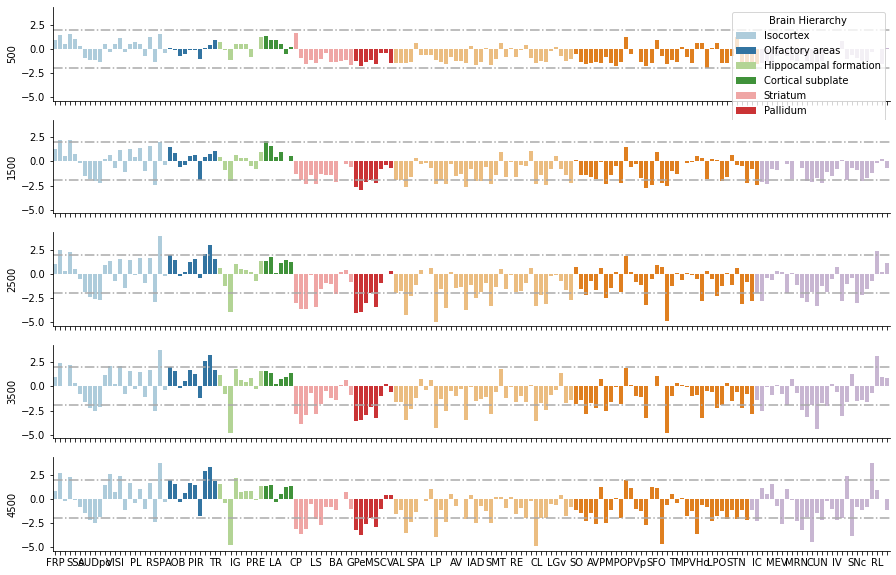

In [71]:
df_levels = upls.create_df_levels(volumes)
fig, axes = plt.subplots(5,1, figsize=(15,10), sharey=True, sharex=True)
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    upls.plot_saliences(df_data=saliences, df_levels=df_levels, 
                        index=1, ax=axes[i], palette='Paired')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(thresholds[i])
    if i!=0:
        axes[i].get_legend().remove()
    sns.despine(left=False, bottom=False)
    n = 4  # Keeps every 7th label
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]

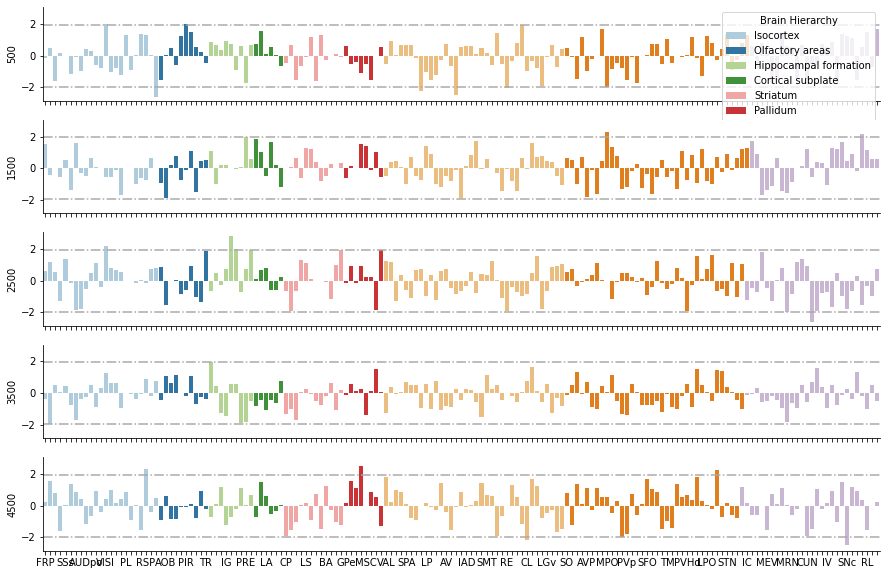

In [74]:
df_levels = upls.create_df_levels(volumes)
fig, axes = plt.subplots(5,1, figsize=(15,10), sharey=True, sharex=True)
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    upls.plot_saliences(df_data=saliences, df_levels=df_levels, 
                        index=2, ax=axes[i], palette='Paired')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(thresholds[i])
    if i!=0:
        axes[i].get_legend().remove()
    sns.despine(left=False, bottom=False)
    n = 4  # Keeps every 7th label
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]